In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t
from scipy import stats
from statsmodels.api import OLS
import statsmodels.api as sm
from warnings import filterwarnings

filterwarnings('ignore')

In [2]:
df = pd.read_csv('Основные аналитические и расчетные показатели(файл FC).csv', sep=';')

In [144]:
print("Всего наблюдений:", df.shape[0])

Всего наблюдений: 193256


In [145]:
df['per'].value_counts()

per
41    48314
42    48314
43    48314
44    48314
Name: count, dtype: int64

In [3]:
df.head()

,per,ter,mest,bud,chlico,chlicn,chisl,chdet,chisd,doxodsn,...,msem,mngd,nps,dhpens,dhinv,dhsinv,dhsdinv,chrab,kvzv,decilrfed
0,41,1,1,1826,2,2,2,0,5,"105722,42",...,0,0,0,0,0,0,0,2,"316,71714",4
1,41,1,1,1827,2,2,2,0,5,"82646,64",...,0,0,0,0,0,0,0,2,"316,71714",2
2,41,1,1,1828,2,2,2,0,5,"88290,20",...,0,0,0,1,0,0,0,3,"316,71714",3
3,41,1,1,1829,2,2,2,0,5,"67953,66",...,0,0,0,1,0,0,0,3,"372,44340",2
4,41,1,1,1830,4,4,4,1,1,"150783,30",...,0,0,0,0,0,0,0,2,"836,58430",2


In [4]:
for el in df.columns:
    if df[el].dtype == 'object':
        df[el] = df[el].apply(lambda x: x.replace(',', '.')).astype(float)

In [25]:
sns.set_style('darkgrid')

In [ ]:
mean_doxod = (df.kvzv * df.doxodsn / 3).sum() / df.kvzv.sum()
dynamics_mean = df.groupby('per').apply(lambda x: (x.kvzv * x.doxodsn / 3).sum() / x.kvzv.sum()).reset_index()
dynamics_mean.columns = ['per', 'mean_doxod']

In [147]:
def weighted_median_func(df):
    d1 = df[['kvzv', 'doxodsn']]
    d1.doxodsn = d1.doxodsn / 3
    d1.sort_values(by='doxodsn', inplace=True)
    d1['kvzv'] = d1['kvzv'].cumsum()
    total_weight = df['kvzv'].sum()
    half_weight = total_weight / 2
    weighted_median = d1[d1['kvzv'] >= half_weight]['doxodsn'].iloc[0]
    return weighted_median

In [148]:
weighted_median = weighted_median_func(df)

In [149]:
dynamics_median = df.groupby('per').apply(lambda x: weighted_median_func(x)).reset_index()
dynamics_median.columns = ['per', 'median_doxod']

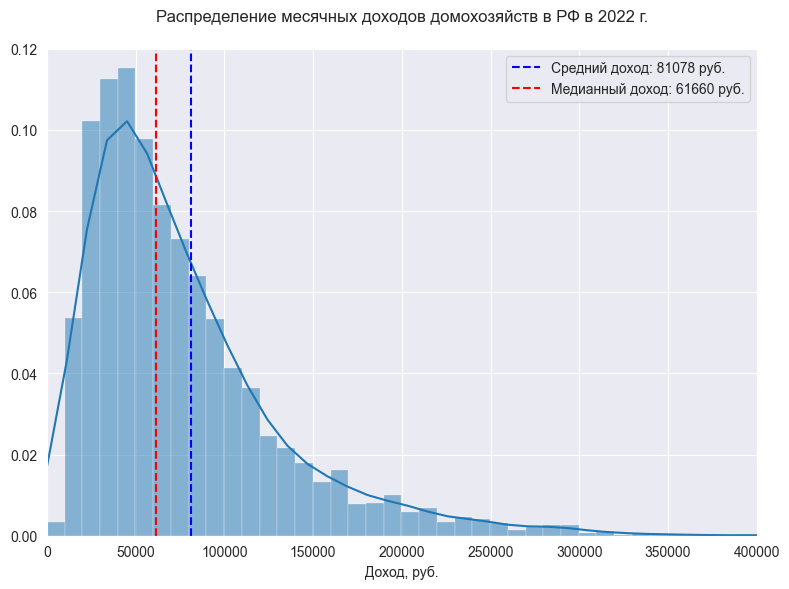

In [150]:
plt.figure(figsize=(8, 6))
sns.histplot(df.assign(doxod=df.doxodsn/3), x='doxod', binwidth=10000, kde=True, weights='kvzv', stat='probability')
plt.xlabel('Доход, руб.')
plt.ylabel('')
plt.title('Распределение месячных доходов домохозяйств в РФ в 2022 г.', pad=20)
plt.vlines(mean_doxod, ymin=0, ymax=0.13, color='b', linestyles='--', label=f'Средний доход: {mean_doxod:.0f} руб.')
plt.vlines(weighted_median, ymin=0, ymax=0.13, color='r', linestyles='--', label=f'Медианный доход: {weighted_median:.0f} руб.')
plt.xlim(0, 400000)
plt.ylim(0, 0.12)
plt.tight_layout()
plt.legend()
plt.savefig('Распределение доходов в РФ в 2022 г.jpg', dpi=700);

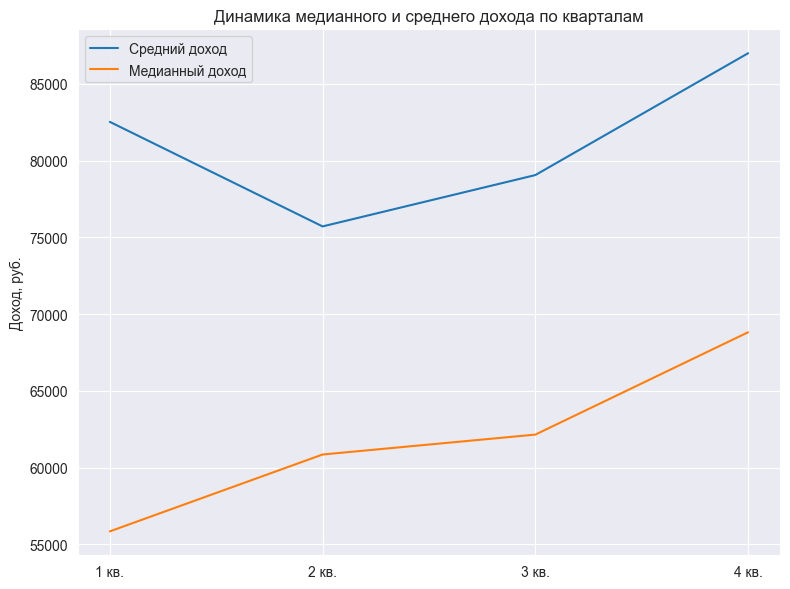

In [151]:
plt.figure(figsize=(8, 6))
sns.lineplot(dynamics_mean, x='per', y='mean_doxod', label='Средний доход')
sns.lineplot(dynamics_median, x='per', y='median_doxod', label='Медианный доход')
plt.title('Динамика медианного и среднего дохода по кварталам')
plt.xticks(ticks=[41, 42, 43, 44], labels=['1 кв.', '2 кв.', '3 кв.', '4 кв.'])
plt.ylabel('Доход, руб.')
plt.xlabel('')
plt.legend()
plt.tight_layout()
plt.savefig('Динамика медианного и среднего дохода по квартала.jpg', dpi=700);

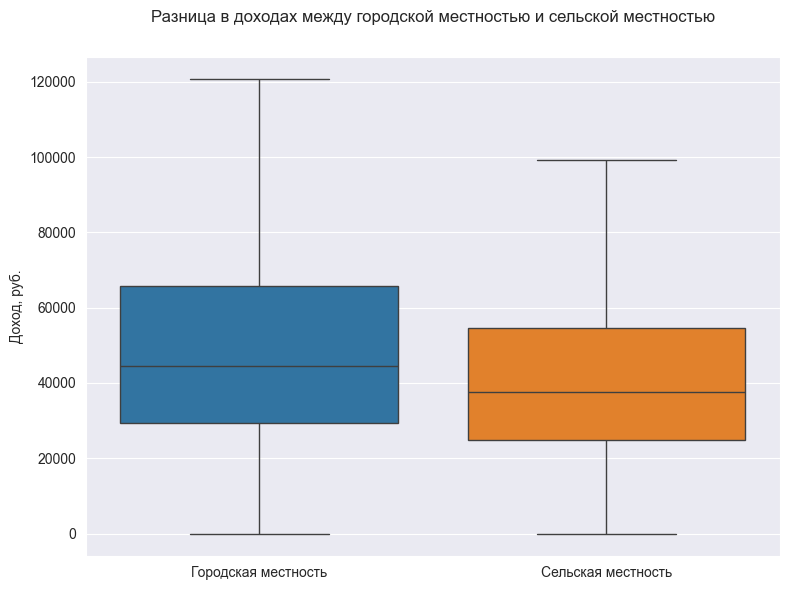

In [137]:
plt.figure(figsize=(8, 6))
plt.title('Разница в доходах между городской местностью и сельской местностью', pad=25)
sns.boxplot(df.assign(doxod=(df.doxodsn * df.kvzv) / 3, 
                      mest=df.mest.map({1: 'Городская местность', 2: 'Сельская местность'})), 
            y='doxod', showfliers=False, x='mest', hue='mest', width=0.8)
plt.ylabel('Доход, руб.')
plt.xlabel('')
plt.tight_layout()
plt.savefig('Разница в доходах между городской местностью и сельской местностью.jpg', dpi=700);

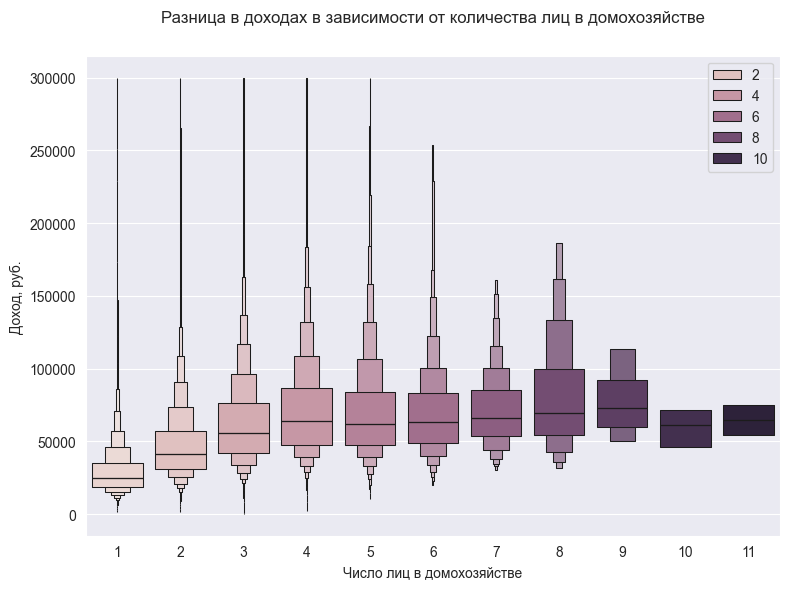

In [177]:
plt.figure(figsize=(8, 6))
plt.title('Разница в доходах в зависимости от количества лиц в домохозяйстве', pad=25)
sns.boxenplot(df.assign(doxod=(df.doxodsn / 3).apply(lambda x: min(x, 3e5))), 
            y='doxod', showfliers=False, x='chlico', hue='chlico', width=0.8)
plt.legend()
plt.ylabel('Доход, руб.')
plt.xlabel('Число лиц в домохозяйстве')
plt.tight_layout()
plt.savefig('Разница в доходах в зависимости от количества лиц в домохозяйстве.jpg', dpi=700);

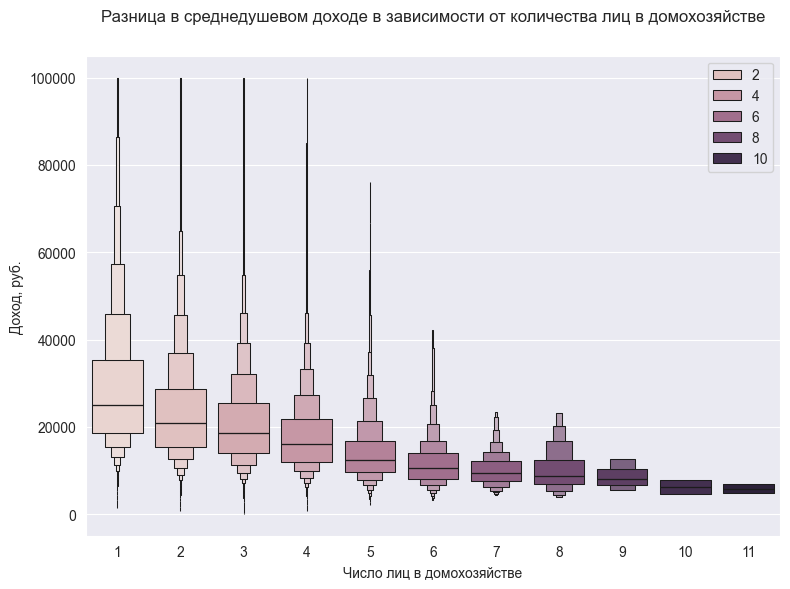

In [178]:
plt.figure(figsize=(8, 6))
plt.title('Разница в среднедушевом доходе в зависимости от количества лиц в домохозяйстве', pad=25)
sns.boxenplot(df.assign(doxod=(df.doxodn / 3).apply(lambda x: min(x, 1e5))), 
            y='doxod', showfliers=False, x='chlico', hue='chlico', width=0.8)
plt.ylabel('Доход, руб.')
plt.xlabel('Число лиц в домохозяйстве')
plt.legend()
plt.tight_layout()
plt.savefig('Разница в среднедушевом доходе в зависимости от количества лиц в домохозяйстве.jpg', dpi=700);

**ГИПОТЕЗА 1**

In [215]:
sample_41 = df[df.per == 41][['doxodsn', 'prod']]
sample_44 = df[df.per == 44][['doxodsn', 'prod']]

In [216]:
statistic, pvalue = stats.ttest_ind(sample_44.doxodsn, sample_41.doxodsn, equal_var=False, alternative='greater')
print(pvalue)

9.700582955773666e-137


In [217]:
statistic, pvalue = stats.ttest_ind((sample_44['prod'] / sample_44.doxodsn).apply(lambda x: min(x, 10)), 
                                    (sample_41['prod'] /sample_41.doxodsn).apply(lambda x: min(x, 10)), 
                                    equal_var=False, alternative='greater')
print(pvalue)

1.7970487005303993e-06


**ГИПОТЕЗА 2**

In [227]:
sample1 = df[df.chlico <= 2][['doxodsn', 'prod']]
sample2 = df[df.chlico > 2][['doxodsn', 'prod']]
sample1 = (sample1['prod'] / sample1['doxodsn']).apply(lambda x: min(x, 10))
sample2 = (sample2['prod'] / sample2['doxodsn']).apply(lambda x: min(x, 10))

In [228]:
sample1.mean(), sample2.mean()

(0.3768923002412934, 0.32822649989859265)

In [232]:
statistic, pvalue = stats.ttest_ind(sample1, sample2, 
                                    equal_var=False, alternative='greater')
print(pvalue)

0.0


In [234]:
statistic, pvalue = stats.ttest_ind(sample1, sample2, 
                                    equal_var=False, alternative='less')
print(pvalue)

1.0


**ГИПОТЕЗА 3**

In [259]:
X = df[['doxodsn', 'prod', 'chlico', 'mest']]
X['PROD_RATIO'] = (X['prod'] / X['doxodsn']).apply(lambda x: min(x, 10))
X = X[['chlico', 'mest', 'PROD_RATIO']]
X = sm.add_constant(X)
X.columns = ['CONST', 'FAM_SIZE', 'TOWN', 'PROD_RATIO']
X.TOWN = X.TOWN.replace({2: 0})
y = X[['PROD_RATIO']]
X['FAM_SIZE*TOWN'] = X['FAM_SIZE'] * X['TOWN']
X.drop(['PROD_RATIO'], axis=1, inplace=True)

In [260]:
print(sm.OLS(y, X).fit().summary())

                            OLS Regression Results                            
Dep. Variable:             PROD_RATIO   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1193.
Date:                Tue, 05 Nov 2024   Prob (F-statistic):               0.00
Time:                        22:40:08   Log-Likelihood:                 46301.
No. Observations:              193256   AIC:                        -9.259e+04
Df Residuals:                  193252   BIC:                        -9.255e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
CONST             0.4130      0.002    253.441

''

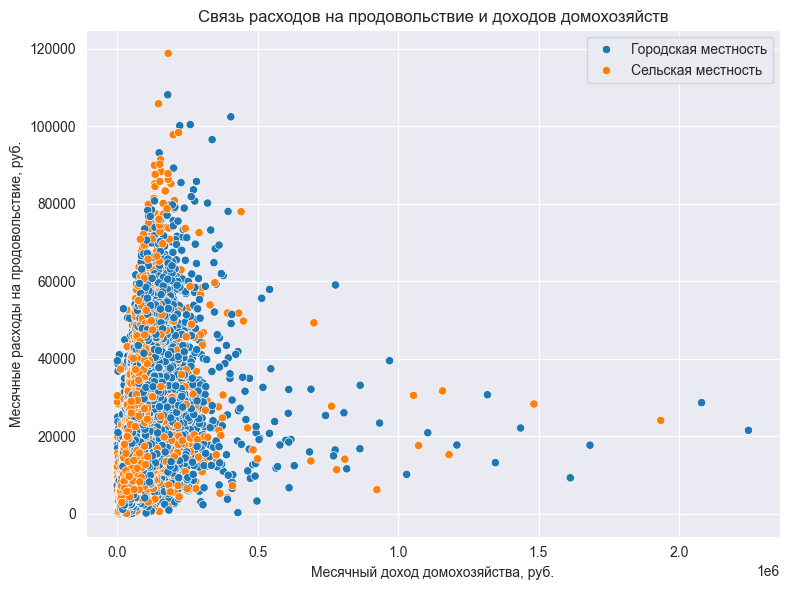

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(df[['doxodsn', 'prod', 'mest']].assign(
    doxodsn=df.doxodsn / 3,
    prod=df['prod'] / 3,
    mest=df.mest.map({1: 'Городская местность', 2: 'Сельская местность'})), 
                x='doxodsn', y='prod', hue='mest')
plt.legend()
plt.xlabel('Месячный доход домохозяйства, руб.')
plt.ylabel('Месячные расходы на продовольствие, руб.')
plt.title('Связь расходов на продовольствие и доходов домохозяйств')
plt.tight_layout()
plt.savefig('Связь расходов на продовольствие и доходов домохозяйств.jpg', dpi=700)
;

In [274]:
df[['doxodsn', 'prod']].corr()

,doxodsn,prod
doxodsn,1.000000,0.554706
prod,0.554706,1.000000


In [283]:
(df['doxodsn']/3).std()

35732.757324625476

In [281]:
alpha = 0.05
sample_variance = np.var(df['doxodsn']/3)
n = df['doxodsn'].shape[0]
chi2_lower = stats.chi2.ppf(alpha / 2, df=n - 1)
chi2_upper = stats.chi2.ppf(1 - alpha / 2, df=n - 1)
lower_bound = (n - 1) * sample_variance / chi2_upper
upper_bound = (n - 1) * sample_variance / chi2_lower
print(f'[{lower_bound:.2f}, {upper_bound:.2f}]')

[1268810824.47, 1284912344.80]


In [285]:
np.sqrt(lower_bound), np.sqrt(upper_bound)

(35620.37091987272, 35845.67400400131)

In [286]:
alpha = 0.05
sample_variance = np.var(df['prod']/3)
n = df['prod'].shape[0]
chi2_lower = stats.chi2.ppf(alpha / 2, df=n - 1)
chi2_upper = stats.chi2.ppf(1 - alpha / 2, df=n - 1)
lower_bound = (n - 1) * sample_variance / chi2_upper
upper_bound = (n - 1) * sample_variance / chi2_lower
print(f'[{lower_bound:.2f}, {upper_bound:.2f}]')

[73040037.95, 73966933.93]


In [287]:
np.sqrt(lower_bound), np.sqrt(upper_bound)

(8546.346467722418, 8600.40312596275)

In [180]:
region_dict = {
    1: "Алтайский край",
    3: "Краснодарский край",
    4: "Красноярский край",
    5: "Приморский край",
    7: "Ставропольский край",
    8: "Хабаровский край",
    10: "Амурская область",
    11: "Архангельская область (без автономного округа)",
    12: "Астраханская область",
    13: "Ненецкий автономный округ",
    14: "Белгородская область",
    15: "Брянская область",
    17: "Владимирская область",
    18: "Волгоградская область",
    19: "Вологодская область",
    20: "Воронежская область",
    22: "Нижегородская область",
    24: "Ивановская область",
    25: "Иркутская область",
    26: "Республика Ингушетия",
    27: "Калининградская область",
    28: "Тверская область",
    29: "Калужская область",
    30: "Камчатский край",
    32: "Кемеровская область",
    33: "Кировская область",
    34: "Костромская область",
    35: "Республика Крым",
    36: "Самарская область",
    37: "Курганская область",
    38: "Курская область",
    40: "Город Санкт-Петербург",
    41: "Ленинградская область",
    42: "Липецкая область",
    44: "Магаданская область",
    45: "Город Москва",
    46: "Московская область",
    47: "Мурманская область",
    49: "Новгородская область",
    50: "Новосибирская область",
    52: "Омская область",
    53: "Оренбургская область",
    54: "Орловская область",
    56: "Пензенская область",
    57: "Пермский край",
    58: "Псковская область",
    60: "Ростовская область",
    61: "Рязанская область",
    63: "Саратовская область",
    64: "Сахалинская область",
    65: "Свердловская область",
    66: "Смоленская область",
    67: "Город Севастополь",
    68: "Тамбовская область",
    69: "Томская область",
    70: "Тульская область",
    71: "Тюменская область (без автономных округов)",
    72: "Ханты-Мансийский автономный округ - Югра",
    73: "Ульяновская область",
    74: "Ямало-Ненецкий автономный округ",
    75: "Челябинская область",
    76: "Забайкальский край",
    77: "Чукотский автономный округ",
    78: "Ярославская область",
    79: "Республика Адыгея",
    80: "Республика Башкортостан",
    81: "Республика Бурятия",
    82: "Республика Дагестан",
    83: "Кабардино-Балкарская Республика",
    84: "Республика Алтай",
    85: "Республика Калмыкия",
    86: "Республика Карелия",
    87: "Республика Коми",
    88: "Республика Марий Эл",
    89: "Республика Мордовия",
    90: "Республика Северная Осетия-Алания",
    91: "Карачаево-Черкесская Республика",
    92: "Республика Татарстан",
    93: "Республика Тыва",
    94: "Удмуртская Республика",
    95: "Республика Хакасия",
    96: "Чеченская Республика",
    97: "Чувашская Республика - Чувашия",
    98: "Республика Саха (Якутия)",
    99: "Еврейская автономная область"
}